In [1]:
import pandas as pd
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import spacy
import random
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import random
import time
import faiss
from nltk.stem import SnowballStemmer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:,.4f}'.format
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

c:\Users\annap\miniconda3\envs\ri-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
SnowballStemmer.languages

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

# Read  Files

In [3]:
fn_files = ['cf74', 'cf75', 'cf76', 'cf77', 'cf78', 'cf79']
fn_queries = 'cfquery'

## Document

In [4]:
def extract_informations(filename):
    data = {}
    id_actual = None
    information = ""

    try:
        with open(filename, "r", encoding='ansi') as file:
            for line in file:
                if line.startswith("RN"): # É o ID
                    # Se há uma informação anterior, armazena no dicionário
                    if id_actual and information:
                        data[id_actual] = information
                        information = ""

                    # Obtém o ID a partir da segunda palavra
                    id_actual = line.split()[1]
                elif line.startswith(("TI", "MJ", "MN", "AB", "EX")) and id_actual:
                    information += line[3:].strip()
                    while True:
                        next_line = file.readline()
                        if not next_line or re.match(r'\b[A-Z]{2}\s', next_line):
                            break
                        information += " " + next_line.strip()

            # Adiciona a última informação ao dicionário
            if id_actual and information:
                data[id_actual] = information

    except FileNotFoundError:
        print("File not founded.")

    return data

# Dicionário para armazenar os data
data_complete = {}

# Extrai as informações de cada file
for fn in fn_files:
    path_file = f"../data/{fn}"
    data = extract_informations(path_file)

    data_complete.update(data)

df_data = pd.DataFrame(list(data_complete.items()), columns=['ID', 'TEXT'])

df_data.head()

,ID,TEXT
0,00001,Pseudomonas aeruginosa infection in cystic fib...
1,00002,Amylase content of mixed saliva in children.SA...
2,00003,A clinical study of the diagnosis of cystic fi...
3,00004,A methodological study of the diagnosis of cys...
4,00005,Proteolytic activity in duodenal juice in infa...


## Query

In [5]:
def read_file_query(file_path):
 
    data = {'QN': [], 'QU': [], 'NR': [], 'RD': []}

    qn_id = None
    qu_texto = None
    nr_numero = None
    rd_lista = []

    with open(file_path, 'r') as arquivo:
        for linha in arquivo:
            if linha.startswith('RD'):
                rd_lista = [int(x) for x in re.findall(r'\d+', linha)]
                while True:
                    try:
                        proxima_linha = next(arquivo)
                        if proxima_linha.startswith('QN'):
                            # Salva os dados acumulados até aqui
                            if qn_id is not None:
                                data['QN'].append(qn_id)
                                data['QU'].append(qu_texto)
                                data['NR'].append(nr_numero)
                                data['RD'].append(rd_lista)
                            # Reinicia as variáveis para o próximo 'QN'
                            qn_id = int(re.search(r'\d+', proxima_linha).group())
                            qu_texto = None
                            nr_numero = None
                            rd_lista = []
                            break
                        rd_lista.extend([int(x) for x in re.findall(r'\d+', proxima_linha)])
                    except StopIteration:
                        break
            elif linha.startswith('QN'):
                qn_id = int(re.search(r'\d+', linha).group())
            elif linha.startswith('QU'):
                qu_texto = linha[3:].strip()
            elif linha.startswith('NR'):
                nr_numero = int(re.search(r'\d+', linha).group())

    # Adiciona os últimos dados, se houver
    if qn_id is not None:
        data['QN'].append(qn_id)
        data['QU'].append(qu_texto)
        data['NR'].append(nr_numero)
        data['RD'].append(rd_lista)

    df = pd.DataFrame(data)
    df["RD"] = df["RD"].apply(lambda x: x[::2])
    df["len(RD)"] = df["RD"].apply(lambda x: len(x))
    
    return df

# Lê o arquivo e cria o DataFrame
df_query = read_file_query(f'../data/{fn_queries}')
df_query.head()

,QN,QU,NR,RD,len(RD)
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",34
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]",7
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",43
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",9
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",131


# Text preprocessing

In [6]:
pp_config = { 'convert': 'lower', # lower or upper 
              'reduce': 'lemming', # stemming or lemming  lemming
              'stop_words': True,  # remove if true else ~remove
              'punctuation':True, # remove if true, else ~remove
              'number': True,
             }

def lemmatize_text_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def remove_stopwords_from_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation_nltk(text):
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens_without_punctuation = [word for word in tokens if word not in string.punctuation]
    
    return ' '.join(tokens_without_punctuation)

def remove_number(text):
    return ' '.join(re.sub(r'\w*\d\w*', '', word) for word in word_tokenize(text))

def preprocess_english_text(text, conf:dict, n_exemple:int):
    
    pp_stats = {}

    if conf['convert'] == 'lower':
        print(f"Before lower ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.lower()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['lower'] = pp_count_words
        print(f"-> After lower ex.:  {text[n_exemple].split('.')[0]}")

    if conf['convert'] == 'upper':
        print(f"Before upper ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.upper()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['upper'] = pp_count_words
        print(f"-> After upper ex.:  {text[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'lemming':
        print(f"Before lemmatizer ex.: {text[n_exemple].split('.')[0]}")
        processed = text.apply(lemmatize_text_spacy)
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After lemmatizer ex.: {processed[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'steamming':
        print(f"Before stemming ex.: {text.iloc[n_exemple].split('.')[0]}")
        processed = text.apply(stem_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After stemming ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['stop_words'] == True:        
        print(f"Before stopword ex.: {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_stopwords_from_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['stop_words'] = pp_count_words
        print(f"-> After stopword ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['punctuation'] == True:
        print(f"Before remove punctuation ex.:  {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_punctuation_nltk)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['punctuation'] = pp_count_words
        print(f"-> After remove ponctuation ex.: {processed.iloc[n_exemple].split('.')[0]}")
    
    if conf['number'] == True:

        print(f"Before remove numbers ex.:  {processed[n_exemple].split('.')[0]}")
        processed = [remove_number(text) for text in processed]
        pp_count_words = [len(text.split()) for text in processed]
        pp_stats['number'] = pp_count_words
        print(f"-> After remove numbers ex.: {processed[n_exemple].split('.')[0]}")

    return processed, pp_stats

In [7]:
df_data = df_data.astype({'ID': int})
df_query = df_query.astype({'QN': int})

In [8]:
print(f"{'-'*50}Data: Document{'-'*50}")
df_data_pp = df_data.copy()
df_data_pp['pp'], pp_count_d= preprocess_english_text(df_data['TEXT'], pp_config, n_exemple=0)

print(f"{'-'*50}Data: Queries{'-'*50}")
df_query_pp = df_query.copy()
df_query_pp['pp'], pp_count_q= preprocess_english_text(df_query['QU'], pp_config, n_exemple=0)

--------------------------------------------------Data: Document--------------------------------------------------
Before lower ex.: Pseudomonas aeruginosa infection in cystic fibrosis
-> After lower ex.:  pseudomonas aeruginosa infection in cystic fibrosis
Before lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis
-> After lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis 
Before stopword ex.: pseudomonas aeruginosa infection in cystic fibrosis 
-> After stopword ex.: pseudomonas aeruginosa infection cystic fibrosis 
Before remove punctuation ex.:  pseudomonas aeruginosa infection cystic fibrosis 
-> After remove ponctuation ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infe

In [9]:
df_query_pp.head()

,QN,QU,NR,RD,len(RD),pp
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",34,effect calcium physical property mucus
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]",7,one distinguish effect mucus hypersecretion
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",43,salivary glycoprotein cf patient different
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",9,lipid composition cf respiratory secretion
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",131,cf mucus abnormal


In [10]:
def contabilize_stats(data, stats)->pd.DataFrame:

    data['lower_len'] = stats['lower']
    data['reduce_len'] = stats['reduce']
    data['stop_len'] = stats['stop_words']
    data['punc_len'] = stats['punctuation']
    data['num_len'] = stats['number']

    return data

df_query_pp = contabilize_stats(df_query_pp, pp_count_q)
df_data_pp = contabilize_stats(df_data_pp, pp_count_d)

df_data_pp.head()

,ID,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85


## Preprocessing reduced by synonyms

In [11]:
def get_vocabulary(data_text, query_text):
    
    data_complete = data_text.to_list()
    data_complete.extend(query_text.to_list())

    words = []

    for phrase in data_complete:
        for word in phrase.split():
            words.append(word)

    return set(words)

def get_synonyms(word):

    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def choose_reference_synonym(synonyms):
    return random.choice(synonyms) if synonyms else None

def replace_synonyms_in_text(text, synonyms_dict):

    if isinstance(text, str):
        words = text.split()
        replaced_words = [synonyms_dict.get(word, word) for word in words]
        return ' '.join(replaced_words)
    else:
        return text

def reduce_vocabulary(data, query, col_text):
 
    vocabulary = get_vocabulary(data[col_text], query[col_text])
    print("Len vocabulary initial:", len(vocabulary))
    
    synonyms_uniques = {}  

    for word in vocabulary:
        synonyms = get_synonyms(word)
        word_reference = choose_reference_synonym(synonyms)
        if word_reference:
            for synonym in synonyms:
                synonyms_uniques[synonym] = word_reference

    print(f"Before synonyms ex.: {data.loc[0, col_text]}")

    # Aplicando a substituição de sinônimos
    r_data = data.copy()
    r_query = query.copy()
    r_data['syn_pp'] = data[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))
    r_query['syn_pp'] = query[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))

    print(f"After synonyms ex.: {data.loc[0, col_text]}")
    vocabulary = get_vocabulary(r_data['syn_pp'], r_query['syn_pp'])
    print("Len vocabulary final:", len(vocabulary))
   
    return r_data, r_query

In [12]:
df_data_pp, df_query_pp = reduce_vocabulary(df_data_pp, df_query_pp, 'pp')

df_data_pp['syn_len'] = df_data_pp['syn_pp'].apply(lambda x: len(x.split()))
df_query_pp['syn_len'] = df_query_pp['syn_pp'].apply(lambda x: len(x.split()))

df_data_pp.head()

Len vocabulary initial: 9308
Before synonyms ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infection respiratory tract  cystic fibrosis patient study mean immunoelectrophoretical analysis patient sera number precipitin pseudomonas aeruginosa concentration  serum protein addition clinical radiographical status lung evaluate use  scoring system precipitin pseudomonas aeruginosa demonstrate sera maximum number one serum  concentration  serum protein significantly change compare match control person notably igg iga elevate acute phase protein change latter suggest active tissue damage concentration  acute phase protein notably haptoglobin correlate number precipitin suggest respiratory tract infection patient man

,ID,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len,syn_pp,syn_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124,pseudomonas aeruginosa infection cystic fibros...,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98,amylase mental_ability amalgamate spittle chil...,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90,clinical take_apart diagnosing cystic fibrosis...,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111,methodological take_apart diagnosing cystic fi...,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85,proteolytic natural_action duodenal succus inf...,85


# Search Engine

## TF-IDF

In [13]:
def tf_idf_technicals(data_documents, data_queries, type:str):

    initial_time = time.time()
    
    if type == 'tf':
        vectorizer = TfidfVectorizer(use_idf=False, norm='l1') 
    elif type == 'idf':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm='l2')  # norm='l2' IDF
    elif type == 'tf-idf':
        vectorizer = TfidfVectorizer()

    document_matrix = vectorizer.fit_transform(data_documents)
    query_vector = vectorizer.transform(data_queries)

    words = vectorizer.get_feature_names_out()

    vector_documents = pd.DataFrame(data=document_matrix.toarray(), columns=words)
    vector_queries = pd.DataFrame(data=query_vector.toarray(), columns=words)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(words)}")
    return vector_documents, vector_queries

In [14]:
# fazer um sem a resução de vocabulário, e outro com a redução, para ver o que vai dar depis 
v_documents, v_queries =  tf_idf_technicals(df_data_pp['pp'], df_query_pp['pp'], 'tf-idf')
v_documents.head()

Execution time: 0.14560842514038086s
Size:9283


,aa,aathe,aathis,ab,abalthough,aban,abandon,abdoman,abdomen,abdominal,...,zealand,zellweger,zero,zeta,zinc,zona,zone,zymogen,zymogram,zz
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [15]:
'''v_documents_red, v_queries_red =  tf_idf_technicals(df_data_pp['syn_pp'], df_query_pp['syn_pp'], 'tf-idf')
v_documents_red.head()'''

"v_documents_red, v_queries_red =  tf_idf_technicals(df_data_pp['syn_pp'], df_query_pp['syn_pp'], 'tf-idf')\nv_documents_red.head()"

## Sentence Transform (Embeddings)

In [16]:
model_name= 'paraphrase-MiniLM-L6-v2'

def get_embeddings(model_name:str, data):
    
    initial_time = time.time()
    
    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(data)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(sentence_embeddings)}")
    return sentence_embeddings

print("Embeddings Documents")
e_document = get_embeddings(model_name, df_data_pp['pp'])

print("Embeddings Queries")
e_queries = get_embeddings(model_name, df_query_pp['pp'])

Embeddings Documents
Execution time: 60.679462909698486s
Size:1239
Embeddings Queries
Execution time: 0.7646524906158447s
Size:100


In [17]:
len(e_document), e_document[0].shape, len(e_queries), e_queries[0].shape

(1239, (384,), 100, (384,))

In [18]:
'''print("Embeddings Documents")
e_document_red = get_embeddings(model_name, df_data_pp['syn_pp'])

print("Embeddings Queries")
e_queries_red = get_embeddings(model_name, df_query_pp['syn_pp'])

len(e_document_red), e_document_red[0].shape, len(e_queries_red), e_queries_red[0].shape'''

'print("Embeddings Documents")\ne_document_red = get_embeddings(model_name, df_data_pp[\'syn_pp\'])\n\nprint("Embeddings Queries")\ne_queries_red = get_embeddings(model_name, df_query_pp[\'syn_pp\'])\n\nlen(e_document_red), e_document_red[0].shape, len(e_queries_red), e_queries_red[0].shape'

## FAISS

In [19]:
document_ids = df_data_pp['ID'].copy()
query_ids =  df_query_pp['QN'].copy()

In [25]:
import faiss
from sklearn.metrics.pairwise import cosine_similarity
# Distância do Cosseno ou
# Distância de METRIC_Jaccard (para vetores binários)

def apply_faiss_index(document, document_ids, query, query_ids, dist):

    initial_time = time.time()

    dim = document.shape[1]

    if dist == 'cossine':
        # Crie o índice Flat no FAISS
        index = faiss.IndexFlat(dim, faiss.METRIC_INNER_PRODUCT)
    else: 
        index = faiss.IndexFlat(dim, faiss.METRIC_Jaccard)

    # Converta os embeddings de documentos para float32 e adicione ao índice
    document_float32 = document.astype('float32')
    index.add(document_float32)

    # Query e obtenção das similaridades
    similarities_data = []

    k = len(document)  # Recuperar todas as similaridades

    for i in range(len(query_ids)):
        query_id = query_ids[i]
        query_embeddings = query[i].reshape(1, -1).astype('float32')

        start_time = time.time()
        D, I = index.search(query_embeddings, k)  # Recuperar todas as similaridades
 
        query_time  = time.time() - start_time
        # Calcula a similaridade do cosseno usando cosine_similarity
        similarity_scores = cosine_similarity(query_embeddings, document[I[0]])[0]
        
        for j in range(k):
            document_id = document_ids[I[0][j]]
            similarity_score = similarity_scores[j]
            similarities_data.append({'query':query_id, 'document':document_id, 'similarity': similarity_score, 'query_time':query_time})

    df_similarities = pd.DataFrame(similarities_data)
    print(f"Execution Time = {time.time() - initial_time}")

    return df_similarities

result_index = apply_faiss_index(e_document, document_ids, e_queries, query_ids, 'cossine') # cossine dist or void
result_index = result_index.sort_values('similarity', ascending=False)
result_index.head()

Execution Time = 2.567747116088867


,query,document,similarity,query_time
105315,86,1065,0.7553,0.0015
109032,89,1065,0.7332,0.0010
109036,89,1090,0.7283,0.0010
109034,89,778,0.7206,0.0010
109038,89,7,0.7135,0.0010


In [ ]:
# filtrar para considerar somente os result_index com similaridade maior que 0.5
result_index = result_faiss_e[ result_faiss_e['similarity'] > 0.5]
result_index = result_index.groupby("query")['document'].unique().reset_index()
result_index = result_index.copy().rename(columns={'query':'id_query','document':'retrieval'})
result_index = result_index.astype({'id_query':int})
result_index.head()

,id_query,retrieval
0,1,[827]
1,2,"[975, 437, 151]"
2,3,"[439, 445, 633, 856, 256, 1175, 1125]"
3,4,[604]
4,5,"[867, 501, 975, 439, 437, 559, 499, 875, 498, ..."


# Evaluation

In [ ]:
targets = df_query_pp[['QN', 'RD']].copy().rename(columns={"QN":"id_query", "RD":"relevant_documents"})
targets = targets.astype({'id_query':int})
targets.head()

,id_query,relevant_documents
0,1,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ..."
1,2,"[169, 434, 454, 498, 499, 592, 875]"
2,3,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34..."
3,4,"[503, 538, 539, 540, 553, 604, 669, 711, 876]"
4,5,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,..."


In [ ]:
dados = pd.merge(targets, result_index, on='id_query')
dados.head()

,id_query,relevant_documents,retrieval
0,1,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",[827]
1,2,"[169, 434, 454, 498, 499, 592, 875]","[975, 437, 151]"
2,3,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...","[439, 445, 633, 856, 256, 1175, 1125]"
3,4,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",[604]
4,5,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...","[867, 501, 975, 439, 437, 559, 499, 875, 498, ..."


In [24]:
dados['id_query'].unique()

array([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 91, 92, 97, 98, 99])

In [25]:
def calculate_pr_mean_and_individual(dados):

    # Calcular precisão e revocação para cada registro
    precision_scores = []
    recall_scores = []

    for i in range(len(dados)):
        # Obter os documentos relevantes e retornados para a consulta
        relevant_documents = set(dados.loc[i, 'relevant_documents'])
        retrieval = set(dados.loc[i, 'retrieval'])

        # Calcular precisão e revocação
        precision = len(relevant_documents.intersection(retrieval)) / len(retrieval) if len(retrieval) > 0 else 0
        recall = len(relevant_documents.intersection(retrieval)) / len(relevant_documents) if len(relevant_documents) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    # Calcular a média da precisão e revocação
    precision_media = np.mean(precision_scores)
    recall_media = np.mean(recall_scores)

    consultas_metrics = pd.DataFrame({
        'id_query': dados['id_query'],
        'precision': precision_scores,
        'recall': recall_scores
    })

    # Criar a tabela de precisão e revocação média
    tabela_media = pd.DataFrame({
        'Métrica': ['Precision Média', 'Recall Médio'],
        'Valor': [precision_media, recall_media]
    })

    return consultas_metrics, tabela_media


In [26]:
consultas_metrics, tabela_media = calculate_pr_mean_and_individual(dados)
consultas_metrics

,id_query,precision,recall
0,1,1.0000,0.0294
1,2,0.0000,0.0000
2,3,0.5714,0.0930
3,4,1.0000,0.1111
4,5,0.8462,0.0840
...,...,...,...
75,91,0.6786,0.0625
76,92,0.7273,0.0741
77,97,0.7500,0.2727
78,98,0.0000,0.0000


In [27]:
tabela_media

,Métrica,Valor
0,Precision Média,0.5116
1,Recall Médio,0.1290


## PR nivel

In [28]:
dados.head()

,id_query,relevant_documents,retrieval
0,1,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",[827]
1,2,"[169, 434, 454, 498, 499, 592, 875]","[975, 437, 151]"
2,3,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...","[439, 445, 633, 856, 256, 1175, 1125]"
3,4,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",[604]
4,5,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...","[867, 501, 975, 439, 437, 559, 499, 875, 498, ..."


c:\Users\annap\miniconda3\envs\ri-env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\annap\miniconda3\envs\ri-env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


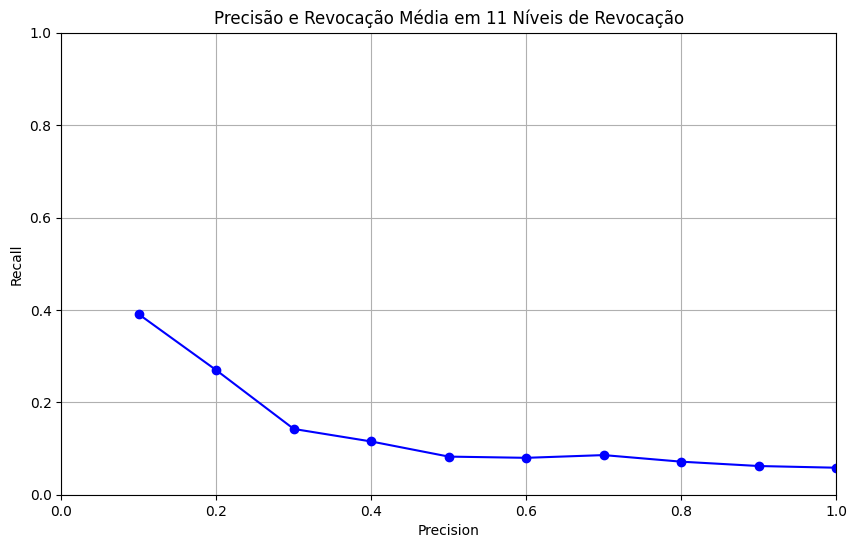

In [29]:
def calculate_precision_recall_table(dados):
    # Níveis de revocação (0 a 1 em incrementos de 0.1)
    revocacao_niveis = np.arange(0, 1.1, 0.1)
    
    precision_list = []
    recall_list = []
    
    total_samples = len(dados)
    
    for revocacao_nivel in revocacao_niveis:
        # Calcular o número de amostras a serem consideradas (10% dos dados)
        num_samples = int(total_samples * revocacao_nivel)
        
        precision_scores = []
        recall_scores = []
        
        for i in range(num_samples):
            relevant_documents = set(dados.loc[i, 'relevant_documents'])
            retrieval = set(dados.loc[i, 'retrieval'])
            
            # Calcular o número de documentos relevantes que deveriam ser recuperados
            num_relevantes = len(relevant_documents)
            
            # Calcular o número de documentos relevantes recuperados
            num_recuperados = len(relevant_documents.intersection(retrieval))
            
            # Calcular a precisão
            precisao = num_recuperados / num_samples if num_samples > 0 else 0
            
            # Calcular a revocação
            revocacao = num_recuperados / num_relevantes if num_relevantes > 0 else 0
            
            precision_scores.append(precisao)
            recall_scores.append(revocacao)
        
        # Calcular a média da precisão e revocação para este nível de revocação
        precision_list.append(np.mean(precision_scores))
        recall_list.append(np.mean(recall_scores))
    
    # Criar a tabela de Precisão x Revocação
    tabela_precision_recall = pd.DataFrame({
        'recall_level': revocacao_niveis,
        'precision': precision_list,
        'recall': recall_list
    })
    
    return tabela_precision_recall


def plot_pr(tabela_precision_recall):

    plt.figure(figsize=(10, 6))
    plt.plot(tabela_precision_recall['recall_level'], tabela_precision_recall['precision'],  marker='o', linestyle='-', color='b')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Precisão e Revocação Média em 11 Níveis de Revocação')
    plt.grid(True)
    plt.show()

tabela_precision_recall = calculate_precision_recall_table(dados)

plot_pr(tabela_precision_recall)

In [30]:
def calcular_metricas(dados):
    metricas = []

    for i in range(len(dados)):
        consulta_id = dados.loc[i, 'id_query']
        documentos_algoritmo = set(dados.loc[i, 'retrieval'])
        relevant_documents_consulta = set(dados.loc[i, 'relevant_documents'])
        
        tp = len(relevant_documents_consulta.intersection(documentos_algoritmo))
        precision = tp / len(documentos_algoritmo) if len(documentos_algoritmo) > 0 else 0
        recall = tp / len(relevant_documents_consulta) if len(relevant_documents_consulta) > 0 else 0
        p_at_5 = len(relevant_documents_consulta.intersection(set(dados.loc[i, 'retrieval'][:5]))) / 5
        p_at_10 = len(relevant_documents_consulta.intersection(set(dados.loc[i, 'retrieval'][:10]))) / 10

        metricas.append({
            'id_query': consulta_id,
            'precision': precision,
            'recall': recall,
            'p@5': p_at_5,
            'p@10': p_at_10
        })

    return pd.DataFrame(metricas)


# Calcular métricas
metrics_df = calcular_metricas(dados)

# Visualizar o DataFrame de métricas
print("Métricas:")
metrics_df.head()

Métricas:


,id_query,precision,recall,p@5,p@10
0,1,1.0000,0.0294,0.2000,0.1000
1,2,0.0000,0.0000,0.0000,0.0000
2,3,0.5714,0.0930,0.6000,0.4000
3,4,1.0000,0.1111,0.2000,0.1000
4,5,0.8462,0.0840,1.0000,1.0000


In [38]:
metrics_df[['precision', 'recall', 'p@5', 'p@10']].mean() 

precision   0.5116
recall      0.1290
p@5         0.4225
p@10        0.3100
dtype: float64

Precisão (Precision): A proporção dos documentos recuperados que são relevantes.
Revocação (Recall): A proporção dos documentos relevantes que foram recuperados.
P@5 (Precision at 5): A precisão considerando apenas os primeiros 5 documentos recuperados.
P@10 (Precision at 10): A precisão considerando apenas os primeiros 10 documentos recuperados.

## Histogram e MRR

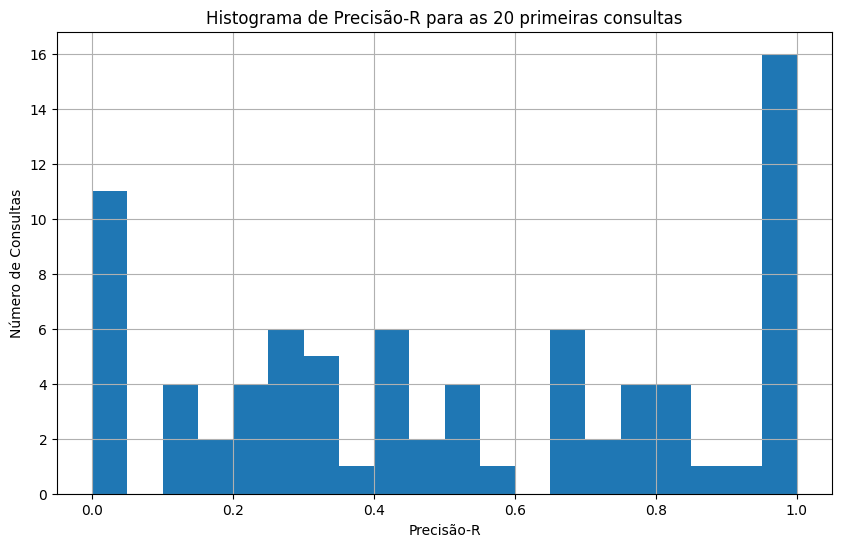

MRR(Q) considerando Sh = 5: 1.0


In [32]:
def plot_hist_and_mrr(metrics_df):
    # Calcular o rank para cada consulta
    metrics_df['rank'] = metrics_df.groupby('id_query').cumcount() + 1

    # Calcular o rank para cada consulta
    metrics_df['reciprocal_rank'] = 1 / (metrics_df['rank'])  # O inverso do rank é o reciprocal rank

    # Calcular MRR(Q) considerando Sh = 5
    Sh = 5
    mrr = metrics_df[metrics_df['rank'] <= Sh].groupby('id_query')['reciprocal_rank'].max().mean()

    # Traçar o histograma da precisão-R para as 20 primeiras consultas
    plt.figure(figsize=(10, 6))  # Movido para aqui
    plt.hist(metrics_df[metrics_df['rank'] <= 20]['precision'], bins=20)
    plt.xlabel('Precisão-R')
    plt.ylabel('Número de Consultas')
    plt.title('Histograma de Precisão-R para as 20 primeiras consultas')
    plt.grid(True)
    plt.show()

    print('MRR(Q) considerando Sh = 5:', mrr)
# Suponha que você tenha um DataFrame 'metrics_df'
plot_hist_and_mrr(metrics_df)